# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import cfunc, vectorize
from numba.types import intc, CPointer, float64
import numpy as np
import os
import pickle
from scipy import LowLevelCallable
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
from scipy.interpolate import griddata
import itertools

from background_models import bg_dampe, bg_alt
from constants import plot_obs, dampe_es, dampe_excess_iflux, fermi_psf
from constants import dampe_excess_bin_low, dampe_excess_bin_high
from constants import speed_of_light, kpc_to_cm, rho_earth
from constants import plot_obs, t_diff, t_loss, dampe_bins

from finite_clump import rho, luminosity, lum_to_rho_norm, mass
from finite_clump import normalize_clump_dampe, luminosity_dampe
from finite_clump import dphi_de_e, dphi_de_e_dampe
from finite_clump import dphi_de_gamma, dphi_de_gamma_dampe
from finite_clump import gamma_ray_extent, constrain_ep_spec
from nfw_clump import NFW_params
from tt_clump import TT_params

from pointlike_clump import dphi_de_e_pt, dphi_de_e_dampe_pt, lum_dampe_pt
from pointlike_clump import dphi_de_gamma_pt, dphi_de_gamma_dampe_pt
from pointlike_clump import constrain_ep_spec_pt

colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

In [3]:
def log_levels(data, n=10):
    return np.logspace(np.log10(np.nanmin(data)), np.log10(np.nanmax(data)), n)

In [40]:
lum_levels = [9e30, 2e31, 5e31, 9e31, 2e32, 5e32, 9e32, 2e33]
rho_rel_levels = [1.01, 1.2, 1.7, 3, 5, 9, 15, 25, 45, 85]
dphi_de_g_levels = [1e-16, 2e-16, 4e-16, 8e-16, 1e-15, 2e-15, 4e-15, 1e-14, 4e-14, 7e-14]
extent_levels = [1, 3, 6, 15, 30, 60, 125, 250, 350, 450]

# If there is an excess greater than this many sigma in another bin,
# the line width constraint is considered violated
n_sigma = 3.

# Clump profile comparison

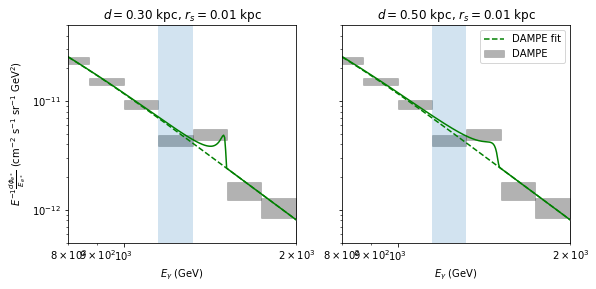

In [4]:
# rs = 10
rs = 1e-2
gamma_nfw = 0.5
power = 0
if power == 3:
    es = np.linspace(1e2, 2e3, 200)
elif power == 0:
    es = np.linspace(8e2, 2e3, 200)

# dists = [1e-2, 5e-2]
dists = [0.3, 0.5]
fig, axs = plt.subplots(1, len(dists), sharey=True, figsize=(9, 4))

for i, d in enumerate(dists):
    ax = axs[i]
    
    # Plot clump spectrum
    params = normalize_clump_dampe(d, NFW_params(rs, 1., gamma_nfw),
                                   bg_dampe)
    ax.loglog(es, [e**power *
                   (dphi_de_e(e, d, params, dampe_excess_bin_high) +
                    bg_dampe(e)) for e in es], "g")

    # Plot background spectrum
    ax.loglog(es, es**power * bg_dampe(es), '--g', label="DAMPE fit")
#     ax.loglog(es, es**power * bg_alt(es), '--k', label="Fit A")

    # Plot DAMPE observations
    plot_obs(power, ax, False)

    # Highlight bin that dictates line width constraint for DAMPE's
    # background model
    ax.axvspan(*dampe_bins[28], alpha=0.2)

    ax.set_xlim(es[[0, -1]])

    if power == 3:
        ax.set_ylim(5e-3, 2e-2)
    elif power == 0:
        ax.set_ylim(5e-13, 5e-11)
    if i == len(dists) - 1:
        ax.legend()
    ax.set_xlabel(r"$E_\gamma$ (GeV)")
    if i == 0:
        ax.set_ylabel(r"$E^{%i} \frac{d \phi_{e^\pm}}{E_{e^\pm}}$ "
                      "(cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^2$)" %
                      (power - 1))
    ax.set_title(r"$d = %.2f$ kpc, $r_s = %.2f$ kpc" % (d, rs))
    
# fig.savefig("figures/line_width_comparison_2.png")

## Comparing relevant distance scales

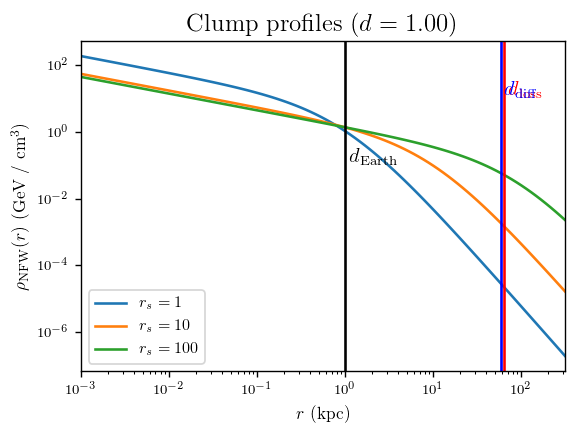

In [25]:
dists = np.logspace(-3, 2.5, 100)
d = 1e0
gamma = 0.5

for rs, c in zip([1e0, 1e1, 1e2], colors):
    plt.plot(dists,
             rho(dists, normalize_clump_dampe(d, NFW_params(rs, 1., gamma),
                                              bg_dampe)),
             c, label=r"$r_s = %i$" % rs)
#     plt.axvline(rs, linestyle='--', color=c)

# Earth's position
plt.axvline(d, color='k')
plt.text(1.1*d, 1e-1, r"$d_{\mathrm{Earth}}$", color='k')

# Energy loss distance
d_loss = t_loss(dampe_excess_bin_high) * speed_of_light / kpc_to_cm
plt.axvline(d_loss, color='r')
plt.text(1.1*d_loss, 1e1, r"$d_{\mathrm{loss}}$", color='r')

# Diffusion distance
d_diff = t_diff(dampe_excess_bin_high, d) * speed_of_light / kpc_to_cm
plt.axvline(d_diff, color='b')
plt.text(1.1*d_diff, 1e1, r"$d_{\mathrm{diff}}$", color='b')

plt.autoscale(axis='x', tight=True)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$r$ (kpc)")
plt.ylabel(r"$\rho_{\mathrm{NFW}}(r)$ (GeV / cm$^3$)")
plt.title(r"Clump profiles ($d = %.2f$)" % d)
plt.legend()

# plt.savefig("figures/profile_comparison.pdf")

## Some random choices

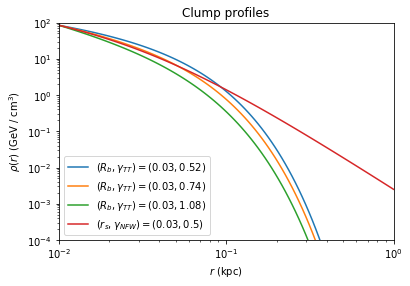

In [46]:
rs = np.logspace(-2, 0, 100)
rho_nfw_ref = rho(rs[0], NFW_params(rs=3e-2, rhos=100., gamma=0.5))
Rb = 3e-2

for gamma in [0.52, 0.74, 1.08]:
    rho_ref = rho(rs[0], TT_params(Rb=Rb, rho0=50., gamma=gamma))
    norm = rho_nfw_ref / rho_ref
    plt.plot(rs, norm * rho(rs, TT_params(Rb=Rb, rho0=50., gamma=gamma)),
             label=r"$(R_b, \gamma_{TT}) = (0.03, %.2f)$" % gamma)

plt.plot(rs, rho(rs, NFW_params(rs=Rb, rhos=100., gamma=0.5)),
         label=r"$(r_s, \gamma_{NFW}) = (0.03, 0.5)$")

plt.autoscale(axis='x', tight=True)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4, 1e2)
plt.xlabel(r"$r$ (kpc)")
plt.ylabel(r"$\rho(r)$ (GeV / cm$^3$)")
plt.title("Clump profiles")
plt.legend()

# plt.savefig("figures/profile_comparison.pdf")

# $e^- + e^+$ spectrum and halo profiles

## NFW

(288.4, 331.1)
(0.01, 509.5672005254202, 1.082880583214835)
(288.4, 331.1)
(0.1, 19.439603613986456, 1.0838304650458446)
(288.4, 331.1)
(1.0, 1.673766047332524, 1.1005949807155433)
(1148.2, 1318.3)
(10.0, 0.32765520869554, 2.0117006218392492)
(1148.2, 1318.3)
(100.0, 0.09572449248536226, 2.4259933276036247)


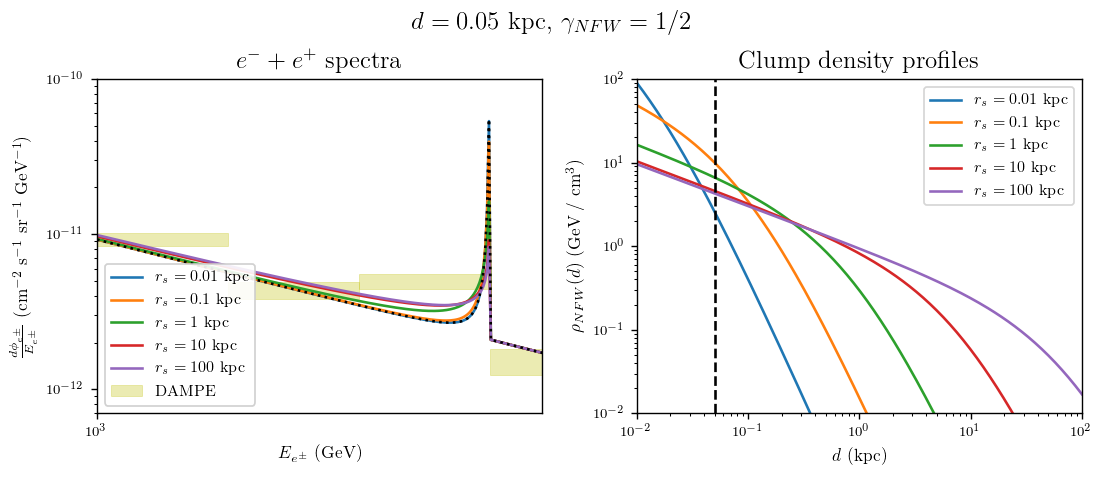

In [15]:
d = 5e-2
gamma_nfw = 0.5
bg = bg_alt

es = np.linspace(1e3, 1.6e3, 200)
# es = np.logspace(1, np.log10(1.6e3), 200)
dists = np.logspace(-2, 2, 200)

plt.figure(figsize=(9, 4))

for rs in [0.01, 0.1, 1., 10., 100.]:
    # Fix rho_s to reproduce DAMPE excess
    params = normalize_clump_dampe(d, NFW_params(rs, 1., gamma_nfw), bg)
    label = r"$r_s = %g$ kpc" % rs
    # Print density normalization, significant of largest excess
    print(rs, params.rhos,
          constrain_ep_spec(d, dampe_excess_bin_high, params, bg,
                            debug_msgs=True))

    # Plot clump spectrum
    plt.subplot(1, 2, 1)
    plt.loglog(es,
               [dphi_de_e(e, d, params, dampe_excess_bin_high) + bg(e)
                for e in es],
               label=label)

    # Plot clump density profile
    plt.subplot(1, 2, 2)
    plt.loglog(dists, rho(dists, params), label=label)

plt.subplot(1, 2, 1)
plot_obs(0, False)  # plot DAMPE observations
# Point-like clump spectrum
plt.loglog(es, dphi_de_e_dampe_pt(es, d, bg) + bg(es), ':k')
plt.xlim(es[[0, -1]])
plt.ylim(7e-13, 1e-10)
plt.yscale("log")
plt.xlabel(r"$E_{e^\pm}$ (GeV)")
plt.ylabel(r"$\frac{d \phi_{e^\pm}}{E_{e^\pm}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$)")
plt.title(r"$e^- + e^+$ spectra")
plt.legend(loc="lower left", framealpha=0.90)

plt.subplot(1, 2, 2)
plt.axvline(d, color='k', linestyle='--')
plt.autoscale(axis='x', tight=True)
plt.ylim(1e-2, 1e2)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\rho_{NFW}(d)$ (GeV / cm$^3$)")
plt.title("Clump density profiles")
plt.legend()

plt.suptitle(r"$d = %g$ kpc, $\gamma_{NFW} = 1/2$" % d)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig("figures/ep_spectra_clump_profiles_nfw_2.pdf")

## TT

(0.01, 260.15660808008454, 1.9716439111126187)
(0.1, 10.480905195752191, 2.0299091157766296)
(1.0, 1.1174447531864045, 2.735334847572645)
(10.0, 0.2578930750209012, 3.5581787575828683)
(100.0, 0.07535782694340985, 3.708792600641072)


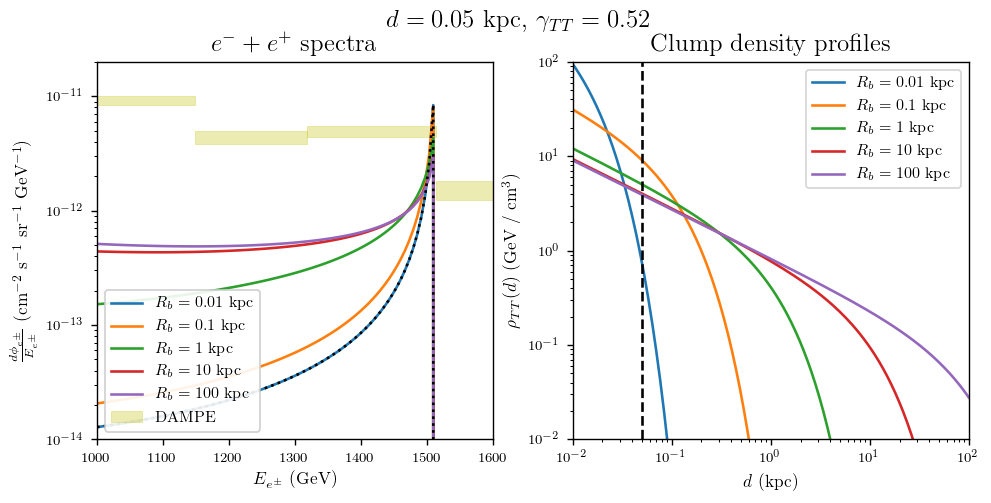

In [202]:
d = 0.05
distances = np.logspace(-2, 2, 200)
gamma_tt = 0.52

plt.figure(figsize=(9, 4))

for Rb in [0.01, 0.1, 1., 10., 100.]:
    # Fix rho_s to reproduce DAMPE excess
    params = normalize_clump_dampe(0.05, TT_params(Rb, 1., gamma_tt), bg_dampe)
    label = r"$R_b = %g$ kpc" % Rb
    # Print density normalization, significant of largest excess
    print(Rb, params.rho0,
          constrain_ep_spec(d, dampe_excess_bin_high, params, bg_dampe))
    
    # Plot clump spectrum
    plt.subplot(1, 2, 1)
    plt.plot(es, [dphi_de_e(e, d, params, dampe_excess_bin_high) for e in es],
             label=label)
    
    # Plot clump density profile
    plt.subplot(1, 2, 2)
    plt.loglog(distances, rho(distances, params), label=label)

plt.subplot(1, 2, 1)
plot_obs(0, False)  # plot DAMPE observations
plt.plot(es, dphi_de_e_dampe_pt(es, d, bg_dampe),  # point-like clump spectrum
         ':k')
plt.xlim(es[[0, -1]])
plt.ylim(1e-14, 2e-11)
plt.yscale("log")
plt.xlabel(r"$E_{e^\pm}$ (GeV)")
plt.ylabel(r"$\frac{d \phi_{e^\pm}}{E_{e^\pm}}$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$)")
plt.title(r"$e^- + e^+$ spectra")
plt.legend(loc="lower left", framealpha=0.90)

plt.subplot(1, 2, 2)
plt.axvline(d, color='k', linestyle='--')
plt.autoscale(axis='x', tight=True)
plt.ylim(1e-2, 1e2)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\rho_{TT}(d)$ (GeV / cm$^3$)")
plt.title("Clump density profiles")
plt.legend()

plt.suptitle(r"$d = %g$ kpc, $\gamma_{TT} = %g$" % (d, gamma_tt))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("figures/ep_spectra_clump_profiles_tt_%g.pdf" % gamma_tt)

# Pointlike clump

In [321]:
e_gamma_ref = 10.
ds = np.logspace(-2, 0, 100)

## $\mathcal{L}$

In [322]:
lums_pt = np.array([lum_dampe_pt(d, bg_dampe) for d in ds])

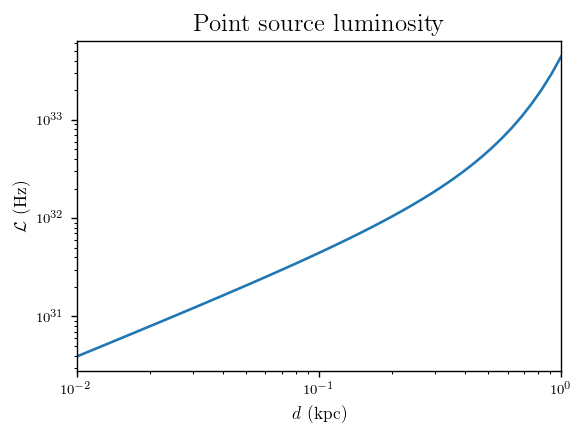

In [344]:
plt.loglog(ds, lums_pt)

plt.autoscale(axis='x', tight=True)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\mathcal{L}$ (Hz)")
plt.title(r"Point source luminosity")
plt.savefig("figures/lum_pt.pdf")

## $\frac{d\phi_\gamma}{dE_\gamma}(E_\gamma = 10~\mathrm{GeV})$

In [323]:
dpdeg_10GeVs_pt = np.array([dphi_de_gamma_pt(e_gamma_ref, d, dampe_excess_bin_high, lum)
                             for lum, d in zip(lums_pt, ds)])

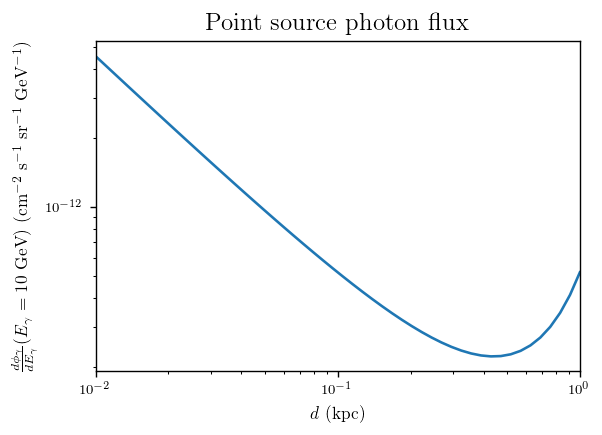

In [345]:
plt.loglog(ds, dpdeg_10GeVs_pt)

plt.autoscale(axis='x', tight=True)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$\frac{d\phi_\gamma}{dE_\gamma}(E_\gamma = 10~\mathrm{GeV})$ (cm$^{-2}$ s$^{-1}$ sr$^{-1}$ GeV$^{-1}$)")
plt.title(r"Point source photon flux")
plt.savefig("figures/gamma_ray_flux_pt.pdf")

## Line width constraints

In [324]:
lw_contrs_pt = np.array([constrain_ep_spec_pt(d, dampe_excess_bin_high, lum, bg_dampe)
                         for lum, d in zip(lums_pt, ds)])

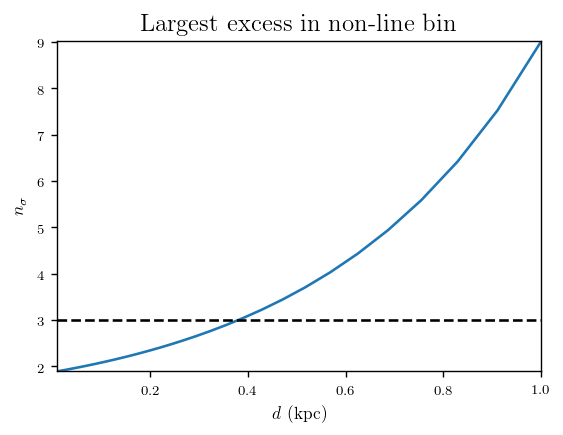

In [346]:
plt.plot(ds, lw_contrs_pt)
plt.axhline(3, color='k', linestyle='--')

plt.autoscale(tight=True)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$n_\sigma$")
plt.title("Largest excess in non-line bin")
plt.savefig("figures/line_width_pt.pdf")

# NFW profile

In [26]:
base_path_nfw = 'data/nfw_gamma_0.5_v3/'

gamma_nfw = 0.5
e_gamma_ref = 10.

ds = np.logspace(-3, np.log10(3), 20)
rss = np.logspace(-2, 2, 20)
d_mg, rs_mg = np.meshgrid(ds, rss)

## $\rho_s$, $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [6]:
rhoss_nfw = np.array([[normalize_clump_dampe(d, NFW_params(rs, 1., gamma_nfw),
                                             bg_dampe).rhos
                       for d in ds]
                      for rs in rss])

rho_rels_nfw = np.array([[(rho(d, NFW_params(rs, rhos, gamma_nfw)) + rho_earth) / rho_earth
                          for rhos, d in zip(rhos_list, ds)]
                         for rhos_list, rs in zip(rhoss_nfw, rss)])

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


### Plot

<a list of 7 text.Text objects>

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


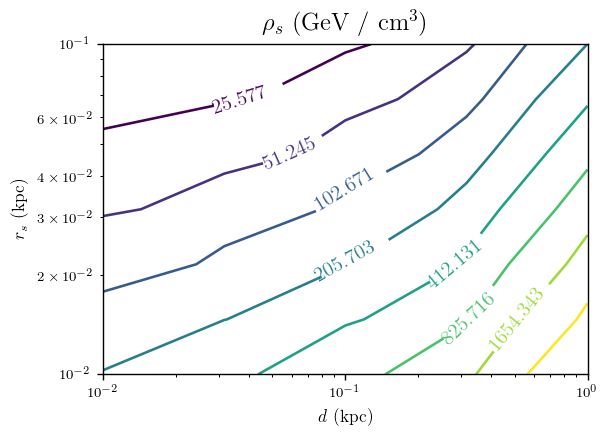

In [8]:
rhoss_cs = plt.contour(d_mg, rs_mg, rhoss_nfw,
                       levels=np.logspace(np.log10(np.nanmin(rhoss_nfw)),
                                          np.log10(np.nanmax(rhoss_nfw)),
                                          10),
                       norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\rho_s$ (GeV / cm$^3$)")

plt.clabel(rhoss_cs, inline=True)

<a list of 8 text.Text objects>

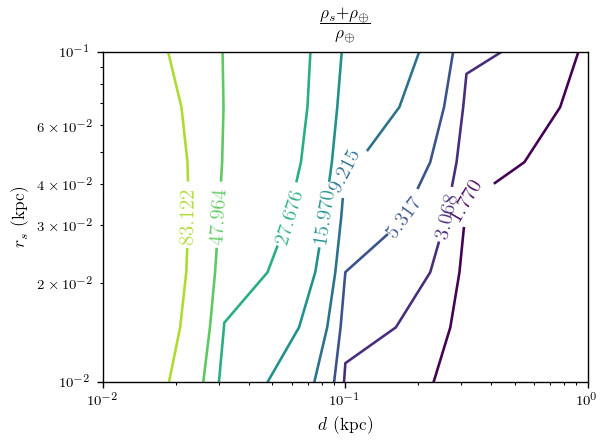

In [10]:
rho_rels_cs = plt.contour(d_mg, rs_mg, rho_rels_nfw,
                          levels=np.logspace(np.log10(np.nanmin(rho_rels_nfw)),
                                             np.log10(np.nanmax(rho_rels_nfw)),
                                             10),
                          norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$")

plt.clabel(rho_rels_cs, inline=True)

## $\mathcal{L}$

In [7]:
lums_nfw = np.array([[luminosity(NFW_params(rs, rhos, gamma_nfw), dampe_excess_bin_high)
                      for rhos in rhos_list]
                     for rs, rhos_list in zip(rss, rhoss_nfw)])

### Plot

<a list of 8 text.Text objects>

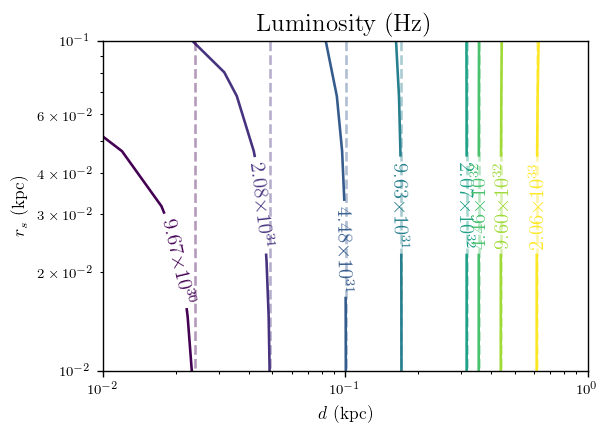

In [14]:
# Clump luminosities
lum_cs = plt.contour(d_mg, rs_mg, lums_nfw,
                     levels=np.logspace(np.log10(np.nanmin(lums_nfw)),
                                        np.log10(np.nanmax(lums_nfw)),
                                        10),
                     norm=LogNorm())
# Point-like luminosities
lum_pt_cs = plt.contour(d_mg, rs_mg, lums_pt,
                        levels=lum_cs.levels,
                        norm=LogNorm(),
                        alpha=0.4,
                        linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"Luminosity (Hz)")

# Format the contour labels
clabels_lums = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in lum_cs.levels}
plt.clabel(lum_cs, inline=True, fmt=clabels_lums)

## $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 10$ GeV)

Compute differential photon flux at $E_\gamma = 10$ GeV for clump and point-like cases.

In [8]:
dpdeg_10GeVs_nfw = np.array([[dphi_de_gamma(e_gamma_ref, fermi_psf, d,
                                        NFW_params(rs, rhos, gamma_nfw),
                                        dampe_excess_bin_high)
                          for d, rhos in zip(ds, rhos_list)]
                         for rs, rhos_list in zip(rss, rhoss_nfw)])

### Plot

<a list of 7 text.Text objects>

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


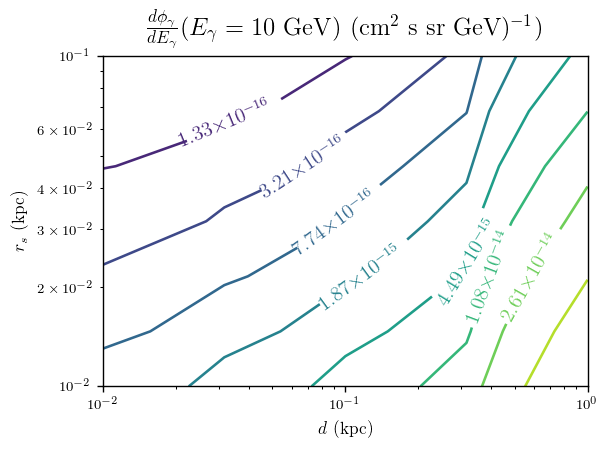

In [8]:
dpdeg_10GeVs_cs = plt.contour(d_mg, rs_mg, dpdeg_10GeVs_nfw,
                              levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs_nfw)),
                                                 np.log10(np.nanmax(dpdeg_10GeVs_nfw)),
                                                 10),
                              norm=LogNorm())

# dpdeg_10GeVs_pt_cs = plt.contour(d_mg, rs_mg, dpdeg_10GeVs_pt,
#                                  levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs_pt)),
#                                                     np.log10(np.nanmax(dpdeg_10GeVs_pt)),
#                                                     10),
#                                  norm=LogNorm(),
#                                  alpha=0.4,
#                                  linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10~\mathrm{GeV})$ "
          r"(cm$^2$ s sr GeV)$^{-1})$")

# Format the contour labels
clabels_dpdeg_10GeVs = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in dpdeg_10GeVs_cs.levels}
plt.clabel(dpdeg_10GeVs_cs, inline=True, fmt=clabels_dpdeg_10GeVs)

### Some horizontal slices through this plot

In [31]:
clump_10GeV_fluxes_d = {}

ds = np.logspace(-2, 0, 50)
rss_vals = np.logspace(-3, -1, 3)
e_gamma_benchmark = 10.

for rs in rss_vals:
    clump_10GeV_fluxes_d[rs] = \
        np.array([dphi_de_gamma_dampe(e_gamma_benchmark,
                                      fermi_psf, d,
                                      NFW_params(rs, 1., gamma_nfw),
                                      bg_dampe)
                  for d in ds]).flatten()

In [33]:
pt_10GeV_fluxes_d = np.array([dphi_de_gamma_dampe_pt([e_gamma_benchmark], d, bg_dampe)
                              for d in ds]).flatten()

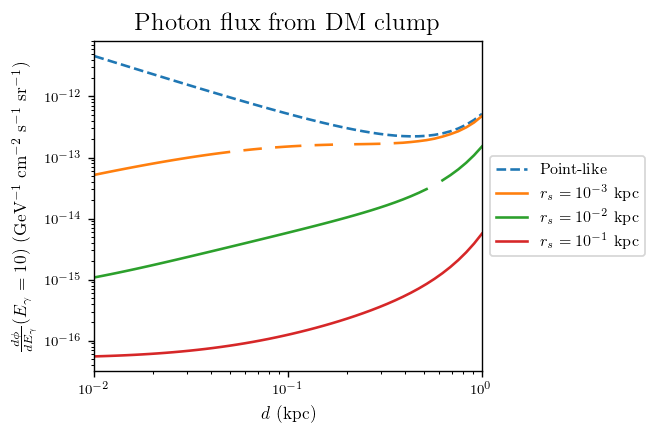

In [34]:
power = 0

plt.plot(ds, e_gamma_benchmark**power * pt_10GeV_fluxes_d, '--', label="Point-like")
for rs in rss_vals:
    plt.plot(ds, e_gamma_benchmark**power * clump_10GeV_fluxes_d[rs],
             label=r"$r_s = 10^{%i}$ kpc" % np.log10(rs))

plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")

plt.title("Photon flux from DM clump")
plt.xlabel(r"$d$ (kpc)")
if power == 0:
    plt.ylabel(r"$\frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
               "(GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)" % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") % (e_gamma_benchmark,
                                                           power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## $\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$

In [9]:
extents_nfw = np.array([[gamma_ray_extent(e_gamma_ref, d, dampe_excess_bin_high,
                                          NFW_params(rs, rhos, gamma_nfw))
                         for rhos, d in zip(rhos_list, ds)]
                        for rhos_list, rs in zip(rhoss_nfw, rss)])

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
Exception ZeroDivisionError: ZeroDivisionError('division by zero',) in "<Numba C callback 'dJ_dr_cf'>" ignored
E

### Plot

<a list of 8 text.Text objects>

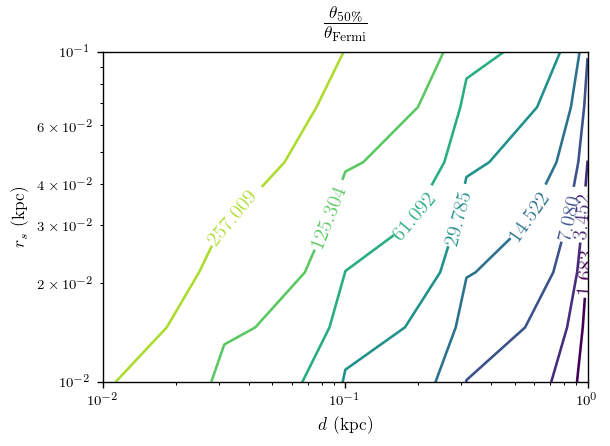

In [38]:
extents_cs = plt.contour(d_mg, rs_mg, extents / fermi_psf,
                         levels=np.logspace(np.log10(np.nanmin(extents / fermi_psf)),
                                            np.log10(np.nanmax(extents / fermi_psf)),
                                            10),
                         norm=LogNorm())

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$")


# Format the contour labels
plt.clabel(extents_cs, inline=True)

## Line width constraint

In [10]:
lw_contrs_nfw = np.array([[constrain_ep_spec(d, dampe_excess_bin_high,
                                             NFW_params(rs, rhos, gamma_nfw), bg_dampe)
                           for rhos, d in zip(rhos_list, ds)]
                          for rhos_list, rs in zip(rhoss_nfw, rss)])

# Line width constraint
# d_max_lw = ds[np.where(lw_contrs_nfw[0, :] > 3)[0][0]]

Remove the bin adjacent to the excess since it drive the constraint almost completely.

In [11]:
lw_contrs_alt_nfw = np.array(
    [[constrain_ep_spec(d, dampe_excess_bin_high,
                        NFW_params(rs, rhos, gamma_nfw), bg_dampe,
                        excluded_idxs=[28])
      for rhos, d in zip(rhos_list, ds)]
     for rhos_list, rs in zip(rhoss_nfw, rss)])

### Plot

Text(0.5,1,'Line width constraint')

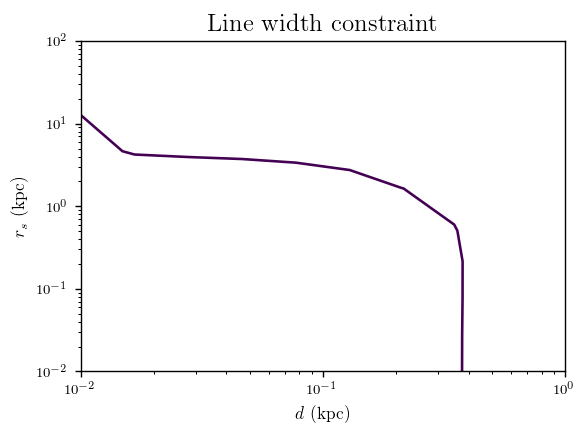

In [38]:
n_sigma = 3.

lw_contrs_cs = plt.contour(d_mg, rs_mg, lw_contrs_nfw,
                           levels=[n_sigma])

# lw_contrs_pt_cs = plt.contour(d_mg, rs_mg, lw_contrs_pt,
#                               levels=[n_sigma], linestyles='dashed')

plt.xlim(ds[[0, -1]])
plt.ylim(rss[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"Line width constraint")

## Clump mass

In [40]:
mass(NFW_params(0.01, 100., gamma_nfw))

142086.25302712066

In [41]:
masses_nfw = np.array([[mass(NFW_params(rs, rhos, gamma_nfw))
                        for rhos in rhos_list]
                       for rs, rhos_list in zip(rss, rhoss_nfw)])

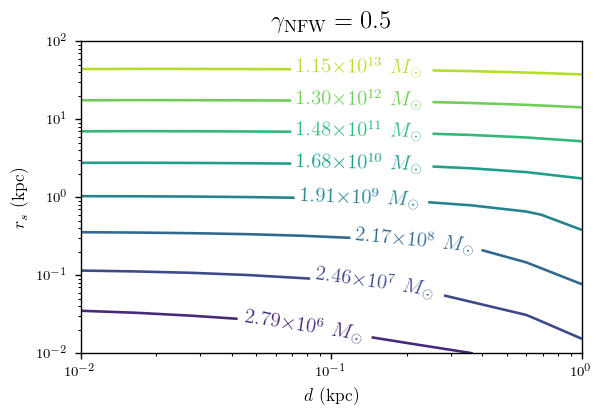

In [42]:
mass_cs = plt.contour(d_mg, rs_mg, masses_nfw,
                      levels=np.logspace(np.log10(np.nanmin(masses_nfw)),
                                         np.log10(np.nanmax(masses_nfw)),
                                         10),
                      norm=LogNorm())

# Only need to do this once
plt.autoscale(tight=True)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$r_s$ (kpc)")
plt.xscale("log")
plt.yscale("log")

# Format the contour labels
clabels_mass = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}~M_\odot$" % np.floor(np.log10(level)))
                for level in mass_cs.levels}
plt.clabel(mass_cs, inline=True, fmt=clabels_mass)

plt.title(r"$\gamma_{\mathrm{NFW}} = %.1f$" % gamma_nfw)
plt.tight_layout()
plt.savefig("figures/mass_contours_nfw.pdf")

## Save results

In [27]:
for var in ["ds", "rss"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var))

for var in ["rhoss", "rho_rels", "lums", "dpdeg_10GeVs",
            "extents", "lw_contrs", "lw_contrs_alt"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"))

## Read results

In [6]:
for var in ["ds", "rss"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv')")

for var in ["rhoss", "rho_rels", "lums", "dpdeg_10GeVs",
            "extents", "lw_contrs", "lw_contrs_alt"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv')")

In [7]:
# Load likelihoods using Ben's processing
ds_pr, rss_pr, prs_nfw = np.loadtxt(
    pr_base_path + "nfw_v2/nfw_gamma_0.5.csv",
    delimiter=',').T

ds_pr = ds_pr.reshape(len(np.unique(ds_pr)), -1)
rss_pr = rss_pr.reshape(ds_pr.shape)
prs_nfw = prs_nfw.reshape(ds_pr.shape)

## Plot everything together

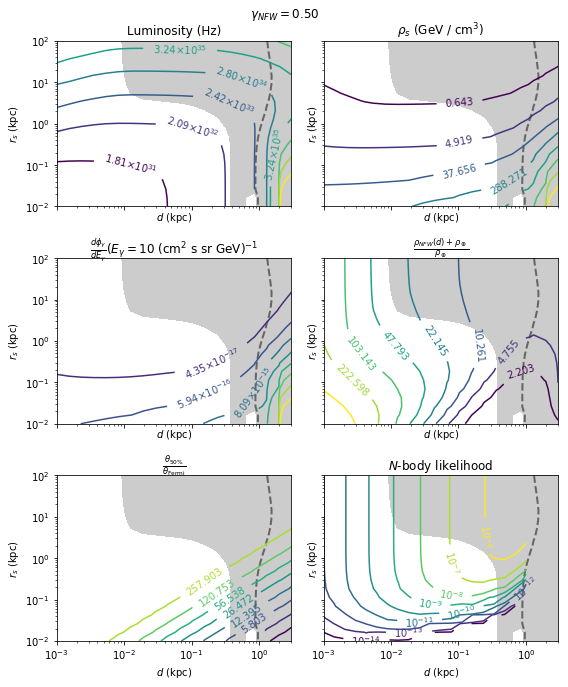

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

for ax in axs.flatten():
    # Label axes
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(d_mg, rs_mg, lw_contrs_nfw,
                levels=[n_sigma, np.max(lw_contrs_nfw)],
                colors='k', alpha=0.2)
    ax.contour(d_mg, rs_mg, lw_contrs_alt_nfw,
               levels=[n_sigma], colors='k', linestyles='--',
               linewidths=2, alpha=0.5)

### Luminosity
ax = axs[0, 0]
ax.set_title(r"Luminosity (Hz)", fontsize=12)

# Clump luminosities
lum_cs = ax.contour(d_mg, rs_mg, lums_nfw,
                    levels=log_levels(lums_nfw),
#                     levels=lum_levels,
                    norm=LogNorm())

# Only need to do this once
ax.set_xlim(ds[[0, -1]])
ax.set_ylim(rss[[0, -1]])
ax.set_xscale("log")
ax.set_yscale("log")

# Format the contour labels
clabels_lums = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in lum_cs.levels}
ax.clabel(lum_cs, inline=True, fmt=clabels_lums)

### Density normalization
ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV / cm$^3$)", fontsize=12)

rhoss_cs = ax.contour(d_mg, rs_mg, rhoss_nfw,
                      levels=log_levels(rhoss_nfw),
                      norm=LogNorm())

ax.clabel(rhoss_cs, inline=True)

### Contribution to local density
ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{NFW}(d) + \rho_\oplus}{\rho_\oplus}$", fontsize=12)

rho_rels_cs = ax.contour(d_mg, rs_mg, rho_rels_nfw,
                         levels=log_levels(rho_rels_nfw),
#                          levels=rho_rel_levels,
                         norm=LogNorm())

ax.clabel(rho_rels_cs, inline=True)

### Photon flux at E_gamma = 10 GeV
ax = axs[1, 0]
ax.set_title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10~\mathrm{GeV})$ "
             r"(cm$^2$ s sr GeV)$^{-1}$", fontsize=12)
dpdeg_10GeVs_cs = ax.contour(d_mg, rs_mg, dpdeg_10GeVs_nfw,
                             levels=log_levels(dpdeg_10GeVs_nfw),
#                              levels=dphi_de_g_levels,
                             norm=LogNorm())

# Format the contour labels
clabels_dpdeg_10GeVs = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in dpdeg_10GeVs_cs.levels}
ax.clabel(dpdeg_10GeVs_cs, inline=True, fmt=clabels_dpdeg_10GeVs)

### Angular extent of gamma rays
ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$")
extents_cs = ax.contour(d_mg, rs_mg, extents_nfw / fermi_psf,
                        levels=log_levels(extents_nfw / fermi_psf),
#                         levels=extent_levels,
                        norm=LogNorm())

ax.clabel(extents_cs, inline=True)

### From Ben
ax = axs[2, 1]
ax.set_title(r"$N$-body likelihood")
# Minimum nonzero probability
min_nonzero_pr = prs_nfw.flatten()[np.where(prs_nfw.flatten() > 0)[0][0]]
pr_cs = ax.contour(ds_pr, rss_pr, prs_nfw,
                   levels=10.**np.arange(-14, -5, 1),
                   norm=LogNorm())

# Format the contour labels
clabels_prs = {level: r"$10^{%i}$" % np.floor(np.log10(level))
                for level in pr_cs.levels}
ax.clabel(pr_cs, inline=True, fmt=clabels_prs)



fig.suptitle(r"$\gamma_{NFW} = %.2f$" % gamma_nfw)
fig.tight_layout(rect=[0, 0.03, 1, 0.975])
# fig.savefig("figures/contour_plots_nfw_gamma_%.1f_v3.pdf" % gamma_nfw)

In [51]:
os.system('say "Done"')

0

# Tidally truncated (TT) profile

In [93]:
gamma_tt_quartiles = [0.516816, 0.74, 1.08222]

gamma_tt = gamma_tt_quartiles[1]
e_gamma_ref = 10.

ds = np.logspace(-3, np.log10(3), 20)
Rbs = np.logspace(-2, 2, 20)

d_mg, Rb_mg = np.meshgrid(ds, Rbs)

base_path_tt = 'data/tt_gamma_%.2f_v2/' % gamma_tt

## $\rho_s$, $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$
Breaks for $\gamma_{TT} = 1.08222$

In [94]:
rho0s_tt_raw = np.array([[normalize_clump_dampe(d, TT_params(Rb, 1., gamma_tt),
                                                bg_dampe).rho0
                          for d in ds]
                         for Rb in Rbs])

Interpolate to fill points missing due to numerical issues. Cubic interpolation seems to work quite well.

In [95]:
obs_idxs = np.where(~np.isnan(rho0s_tt_raw.flatten()))[0]

rho0s_tt = np.exp(griddata(np.array(list(itertools.product(ds, Rbs)))[obs_idxs],
                           np.log(rho0s_tt_raw.flatten())[obs_idxs],
                           (d_mg, Rb_mg),
                           method='cubic')).T

In [96]:
rho_rels_tt = np.array([[(rho(d, TT_params(Rb, rho0, gamma_tt)) + rho_earth) / rho_earth
                          for rho0, d in zip(rho0_list, ds)]
                         for rho0_list, Rb in zip(rho0s_tt, Rbs)])

## $\mathcal{L}$

In [97]:
lums_tt = np.array([[luminosity(TT_params(Rb, rho0, gamma_tt), dampe_excess_bin_high)
                      for rho0 in rho0_list]
                     for Rb, rho0_list in zip(Rbs, rho0s_tt)])

## $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 10$ GeV)

Compute differential photon flux at $E_\gamma = 10$ GeV for clump and point-like cases.

In [98]:
dpdeg_10GeVs_tt = np.array([[dphi_de_gamma(e_gamma_ref, fermi_psf, d,
                                        TT_params(Rb, rho0, gamma_tt),
                                        dampe_excess_bin_high)
                          for d, rho0 in zip(ds, rho0_list)]
                         for Rb, rho0_list in zip(Rbs, rho0s_tt)])

### Some horizontal slices through this plot
Need to fix the numerical issues.

In [59]:
clump_10GeV_fluxes_d = {}

ds = np.logspace(-2, 0, 10)
Rbs_vals = np.logspace(-3, -1, 3)
e_gamma_benchmark = 10.

for Rb in Rbs_vals:
    clump_10GeV_fluxes_d[Rb] = \
        np.array([dphi_de_gamma_dampe(e_gamma_benchmark,
                                      fermi_psf, d,
                                      TT_params(Rb, 1., gamma_tt),
                                      bg_dampe)
                  for d in ds]).flatten()

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
finite_clump.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  rho_norm = np.sqrt(residual_iflux / dm_iflux)


In [60]:
pt_10GeV_fluxes_d = np.array([dphi_de_gamma_dampe_pt([e_gamma_benchmark], d, bg_dampe)
                              for d in ds]).flatten()

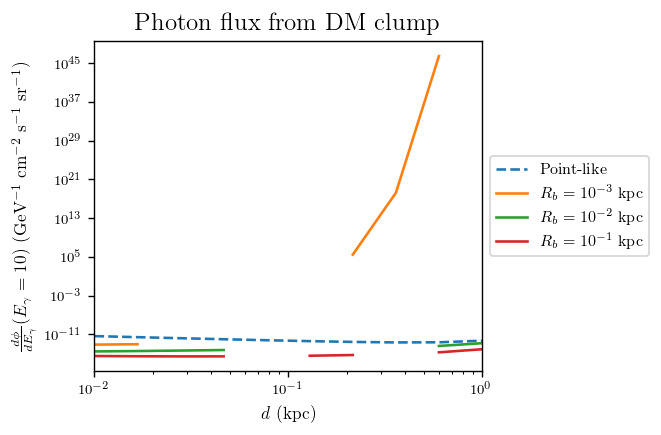

In [61]:
power = 0

plt.plot(ds, e_gamma_benchmark**power * pt_10GeV_fluxes_d, '--', label="Point-like")
for Rb in Rbs_vals:
    plt.plot(ds, e_gamma_benchmark**power * clump_10GeV_fluxes_d[Rb],
             label=r"$R_b = 10^{%i}$ kpc" % np.log10(Rb))

plt.xlim(ds[[0, -1]])
plt.xscale("log")
plt.yscale("log")

plt.title("Photon flux from DM clump")
plt.xlabel(r"$d$ (kpc)")
if power == 0:
    plt.ylabel(r"$\frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
               "(GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$)" % e_gamma_benchmark)
else:
    plt.ylabel((r"$E^%i \frac{d\phi}{dE_\gamma}(E_\gamma = %i)$ "
                r"(GeV$^{%i}$ cm$^2$ $s$ $sr$)$^{-1}$") % (e_gamma_benchmark,
                                                           power, 1-power))

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## $\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
extents_tt = np.array([[gamma_ray_extent(e_gamma_ref, d, dampe_excess_bin_high,
                                          TT_params(Rb, rho0, gamma_tt))
                         for rho0, d in zip(rho0_list, ds)]
                        for rho0_list, Rb in zip(rho0s_tt, Rbs)])

### Not sure how to handle the numerical issues.

In [ ]:
extents_tt_copy = extents_tt.copy()

jump_row_idxs, jump_col_idxs = np.where(np.abs(extents_tt_copy[:, :-1] -
                                               extents_tt_copy[:, 1:]) > 0.1)
jump_col_idxs = jump_col_idxs + 1

extents_tt_copy[jump_row_idxs, jump_col_idxs] = np.nan
extents_tt_copy[jump_row_idxs, jump_col_idxs] = np.nan
extents_tt_copy[jump_row_idxs, jump_col_idxs-1] = np.nan

## Line width constraint

In [100]:
lw_contrs_tt = np.array([[constrain_ep_spec(d, dampe_excess_bin_high,
                                            TT_params(Rb, rho0, gamma_tt), bg_dampe)
                          for rho0, d in zip(rho0_list, ds)]
                         for rho0_list, Rb in zip(rho0s_tt, Rbs)])

In [101]:
lw_contrs_alt_tt = np.array(
    [[constrain_ep_spec(d, dampe_excess_bin_high,
                        TT_params(Rb, rho0, gamma_tt), bg_dampe,
                        excluded_idxs=[28])
      for rho0, d in zip(rho0_list, ds)]
     for rho0_list, rs in zip(rho0s_tt, Rbs)])

### Interpolate the points where there were numerical issues. This doesn't work as well. Not sure what to do.

In [9]:
lw_contrs_tt_raw[lw_contrs_tt_raw == 0] = np.nan
obs_idxs = np.where(~np.isnan(lw_contrs_tt_raw.flatten()))[0]

lw_contrs_tt = griddata(np.array(list(itertools.product(ds, Rbs)))[obs_idxs],
                        lw_contrs_tt_raw.flatten()[obs_idxs],
                        (d_mg, Rb_mg),
                        method='cubic').T

### Check constraint contours

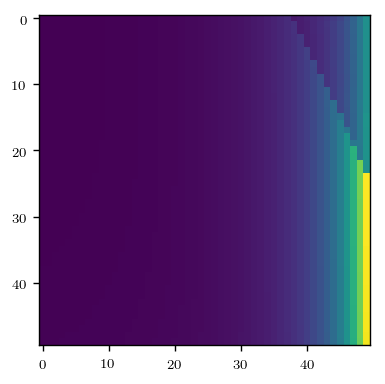

In [10]:
plt.imshow(lw_contrs_tt)

Text(0.5,1,'Line width constraint')

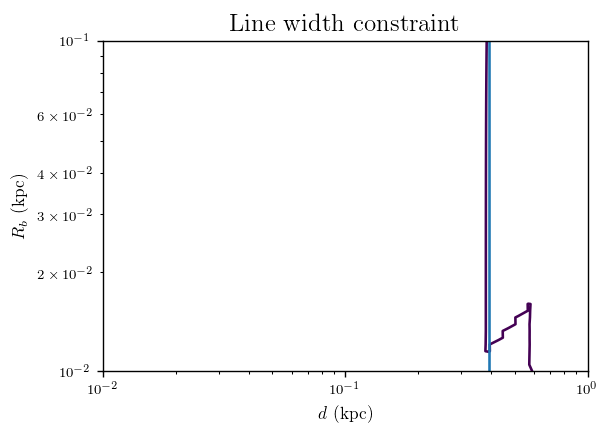

In [15]:
n_sigma = 3.

lw_contrs_cs = plt.contour(d_mg, Rb_mg, lw_contrs_tt,
                           levels=[n_sigma])

# lw_contrs_pt_cs = plt.contour(d_mg, Rb_mg, lw_contrs_pt,
#                               levels=[n_sigma], linestyles='dashed')

d_max_lw_tt = ds[np.where(lw_contrs_tt[lw_contrs_tt.shape[0]/2, :] > 3)[0][0]]
plt.axvline(d_max_lw_tt)

plt.xlim(ds[[0, -1]])
plt.ylim(Rbs[[0, -1]])
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.xscale("log")
plt.yscale("log")
plt.title(r"Line width constraint")

In [12]:
os.system('say "Done"')

0

## Clump mass

In [4]:
masses_tt = np.array([[mass(TT_params(Rb, rho0, gamma_tt))
                        for rho0 in rho0_list]
                       for Rb, rho0_list in zip(Rbs, rho0s_tt)])

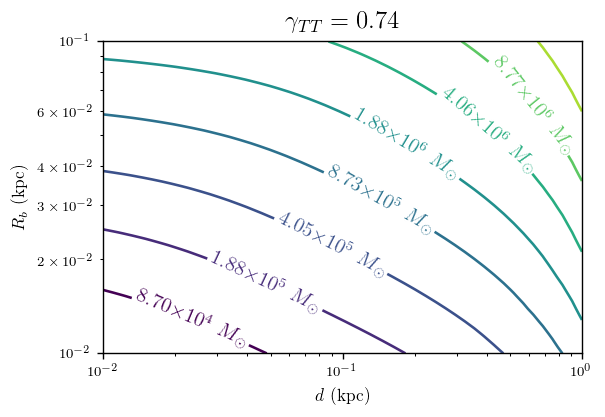

In [7]:
mass_cs = plt.contour(d_mg, Rb_mg, masses_tt,
                      levels=np.logspace(np.log10(np.nanmin(masses_tt)),
                                         np.log10(np.nanmax(masses_tt)),
                                         10),
                      norm=LogNorm())

# Only need to do this once
plt.autoscale(tight=True)
plt.xlabel(r"$d$ (kpc)")
plt.ylabel(r"$R_b$ (kpc)")
plt.xscale("log")
plt.yscale("log")

# Format the contour labels
clabels_mass = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}~M_\odot$" % np.floor(np.log10(level)))
                for level in mass_cs.levels}
plt.clabel(mass_cs, inline=True, fmt=clabels_mass)

plt.title(r"$\gamma_{TT} = %.2f$" % gamma_tt)
plt.tight_layout()
plt.savefig("figures/mass_contours_tt.pdf")

## Save results

In [33]:
for var in ["ds", "Rbs"]:
    np.savetxt(base_path_tt + var + ".csv", eval(var))

for var in ["rho0s", "rho_rels", "lums", "dpdeg_10GeVs",
            "extents", "lw_contrs", "lw_contrs_alt"]:
    np.savetxt(base_path_tt + var + ".csv", eval(var + "_tt"))

## Read results

In [35]:
for var in ["ds", "Rbs"]:
    exec(var + " = np.loadtxt('" + base_path_tt + var + ".csv')")

for var in ["rho0s", "rho_rels", "lums", "dpdeg_10GeVs",
            "extents", "lw_contrs", "lw_contrs_alt"]:
    exec(var + "_tt = np.loadtxt('" + base_path_tt + var + ".csv')")

In [104]:
# Load likelihoods using Ben's processing
ds_pr, Rbs_pr, prs_tt = np.loadtxt(
    pr_base_path + "exp/exp_gamma_%.2f.csv" % gamma_tt,
    delimiter=',').T

ds_pr = ds_pr.reshape(len(np.unique(ds_pr)), -1)
Rbs_pr = Rbs_pr.reshape(ds_pr.shape)
prs_tt = prs_tt.reshape(ds_pr.shape)

## Plot everything together

In [88]:
lum_levels = 10.**np.arange(30, 36)

rho_rel_levels = [1.01, 1.5, 4, 8, 15, 30, 70, 140, 200]

dphi_de_g_levels = np.sort(np.concatenate((10.**np.arange(-20, -12), [5e-18, 3e-17])))

extent_levels = np.logspace(np.log10(20), np.log10(1e3), 10)

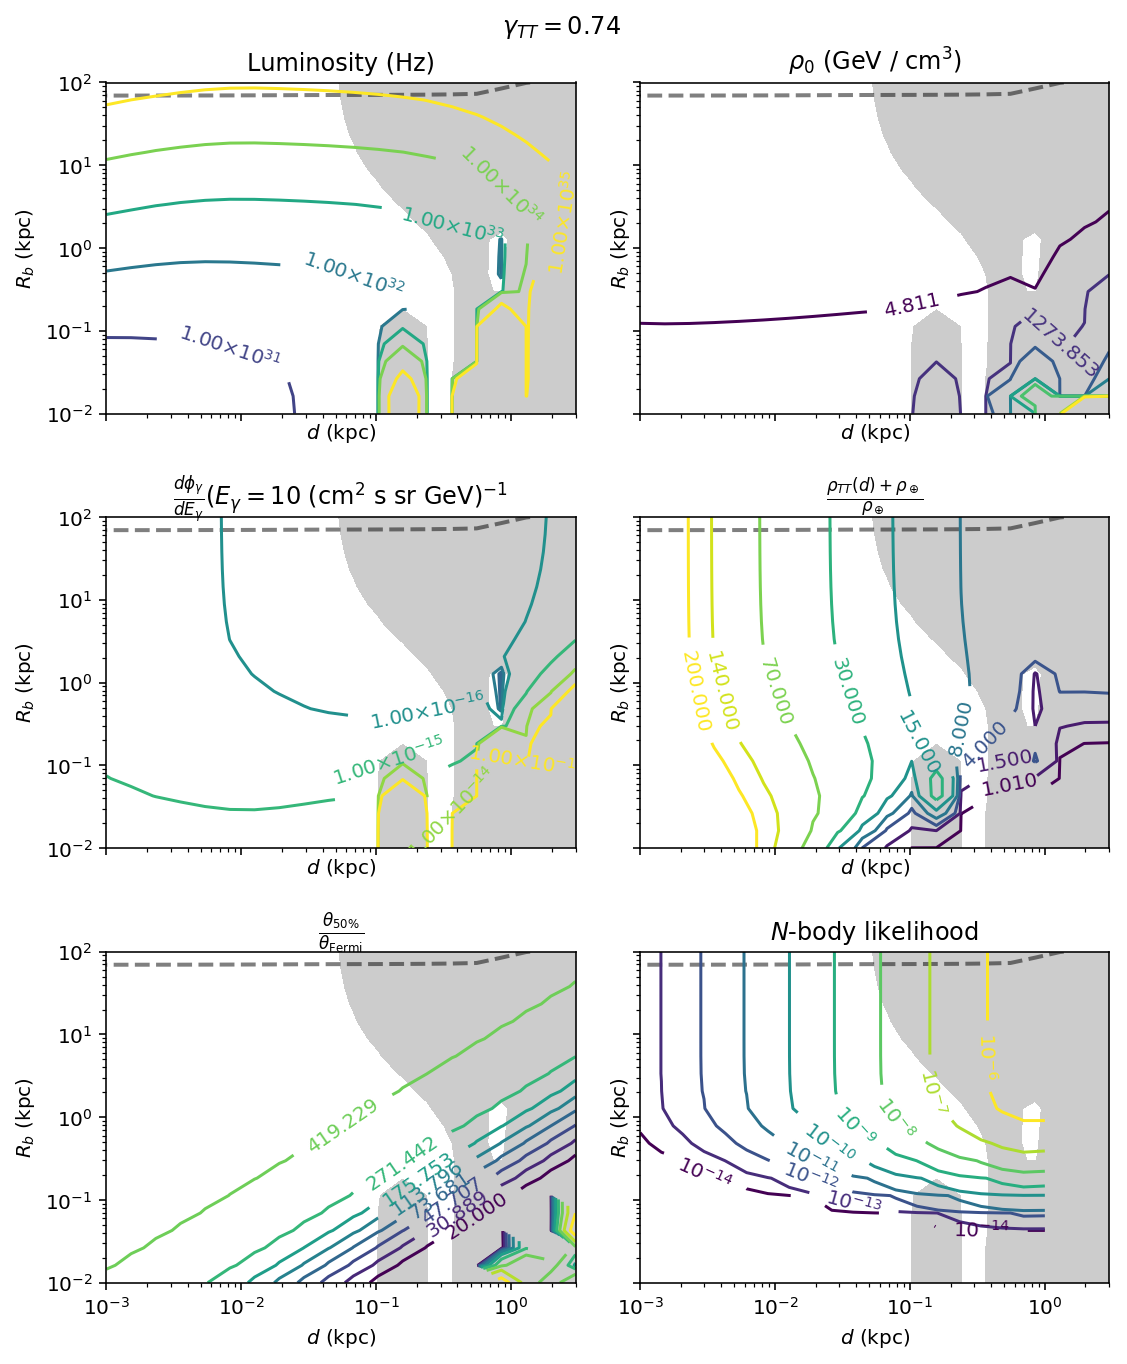

In [105]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

for ax in axs.flatten():
    # Label axes
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$R_b$ (kpc)")
    
    # Line width constraint
    ax.contourf(d_mg, Rb_mg, lw_contrs_tt,
                levels=[n_sigma, np.max(lw_contrs_tt)],
                colors='k', alpha=0.2)
    ax.contour(d_mg, Rb_mg, lw_contrs_alt_tt,
               levels=[n_sigma], colors='k', linestyles='--',
               linewidths=2, alpha=0.5)

### Luminosity
ax = axs[0, 0]
ax.set_title(r"Luminosity (Hz)", fontsize=12)

# Clump luminosities
lum_cs = ax.contour(d_mg, Rb_mg, lums_tt,
#                     levels=np.logspace(np.log10(np.nanmin(lums_tt)),
#                                        np.log10(np.nanmax(lums_tt)),
#                                        10),
                    levels=lum_levels,
                    norm=LogNorm())

# Only need to do this once
ax.set_xlim(ds[[0, -1]])
ax.set_ylim(Rbs[[0, -1]])
ax.set_xscale("log")
ax.set_yscale("log")

# Format the contour labels
clabels_lums = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in lum_cs.levels}
ax.clabel(lum_cs, inline=True, fmt=clabels_lums)

### Density normalization
ax = axs[0, 1]
ax.set_title(r"$\rho_0$ (GeV / cm$^3$)", fontsize=12)

rho0s_cs = ax.contour(d_mg, Rb_mg, rho0s_tt,
#                       levels=np.logspace(np.log10(np.nanmin(rho0s_tt)),
#                                          np.log10(np.nanmax(rho0s_tt)),
#                                          10),
                      levels=log_levels(rho0s_tt),
                      norm=LogNorm())

ax.clabel(rho0s_cs, inline=True)

### Contribution to local density
ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{TT}(d) + \rho_\oplus}{\rho_\oplus}$", fontsize=12)

rho_rels_cs = ax.contour(d_mg, Rb_mg, rho_rels_tt,
#                          levels=np.logspace(np.log10(np.nanmin(rho_rels_tt)),
#                                             np.log10(np.nanmax(rho_rels_tt)),
#                                             10),
                         levels=rho_rel_levels,
                         norm=LogNorm())

ax.clabel(rho_rels_cs, inline=True)

### Photon flux at E_gamma = 10 GeV
ax = axs[1, 0]
ax.set_title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10~\mathrm{GeV})$ "
             r"(cm$^2$ s sr GeV)$^{-1}$", fontsize=12)
dpdeg_10GeVs_cs = ax.contour(d_mg, Rb_mg, dpdeg_10GeVs_tt,
#                              levels=np.logspace(np.log10(np.nanmin(dpdeg_10GeVs_tt)),
#                                                 np.log10(np.nanmax(dpdeg_10GeVs_tt)),
#                                                 10),
                             levels=dphi_de_g_levels,
                             norm=LogNorm())

# Format the contour labels
clabels_dpdeg_10GeVs = {level: (r"%.2f" % (level / 10**np.floor(np.log10(level)))) +
                (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
                for level in dpdeg_10GeVs_cs.levels}
ax.clabel(dpdeg_10GeVs_cs, inline=True, fmt=clabels_dpdeg_10GeVs)

### Angular extent of gamma rays
ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$")
extents_cs = ax.contour(d_mg, Rb_mg, extents_tt / fermi_psf,
                        levels=extent_levels,
                        norm=LogNorm())

ax.clabel(extents_cs, inline=True)

### From Ben
ax = axs[2, 1]
ax.set_title(r"$N$-body likelihood")
# Minimum nonzero probability
min_nonzero_pr = prs_tt.flatten()[np.where(prs_tt.flatten() > 0)[0][0]]
pr_cs = ax.contour(ds_pr, Rbs_pr, prs_tt,
                   levels=10.**np.arange(-14, -5, 1),
                   norm=LogNorm())

# Format the contour labels
clabels_prs = {level: r"$10^{%i}$" % np.floor(np.log10(level))
                for level in pr_cs.levels}
ax.clabel(pr_cs, inline=True, fmt=clabels_prs)



fig.suptitle(r"$\gamma_{TT} = %.2f$" % gamma_tt)
fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_tt_gamma_%.2f_v2.pdf" % gamma_tt)

In [102]:
os.system('say "Done"')

0